In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.insert(0, 'code')

In [3]:
import torch
import torch.nn as nn

import numpy as np

import yaml
import json

from mac import MACNetwork
from utils import load_vocab
from datasets import ClevrDataset, collate_fn
from config import cfg_from_file, _merge_a_into_b
from visualize_attentions import IntermediateLayerGetter, plot_word_img_attn, idxs_to_question

In [4]:
from config import cfg

ds_root = '/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0'

cfg_from_file('./data/big_bsz_complex_12/big_bsz_complex_model_12.yml')
cfg.GPU_ID = '-1'
cfg.CUDA = False
cfg.DATASET.DATA_DIR = os.path.join(ds_root, 'data')

vocab = load_vocab(cfg)
q_tok_to_idx = vocab['question_token_to_idx']
q_idx_to_tok = vocab['question_idx_to_token']
a_tok_to_idx = vocab['answer_token_to_idx']
a_idx_to_tok = vocab['answer_idx_to_token']

In [5]:
split = 'val'

ds = ClevrDataset(
    cfg.DATASET.DATA_DIR,
    sample=False,
    split=split,
)

with open(os.path.join(ds_root, 'questions', f'CLEVR_{split}_questions.json'), 'r') as f:
    ds.questions = json.load(f)['questions']

In [6]:
model = MACNetwork(cfg, vocab)
state = torch.load('data/big_bsz_complex_12/Model/model_checkpoint_000025.pth', map_location='cpu')
model.load_state_dict(state['model'])
model.eval();

return_layers = {
    'mac.control.cw_attn_idty': 'cw_attn',
    'mac.read.kb_attn_idty': 'kb_attn',
}
mid_getter = IntermediateLayerGetter(model, return_layers, keep_output=True)

In [10]:
from visualize_attentions import IntermediateLayerGetter, plot_word_img_attn, idxs_to_question

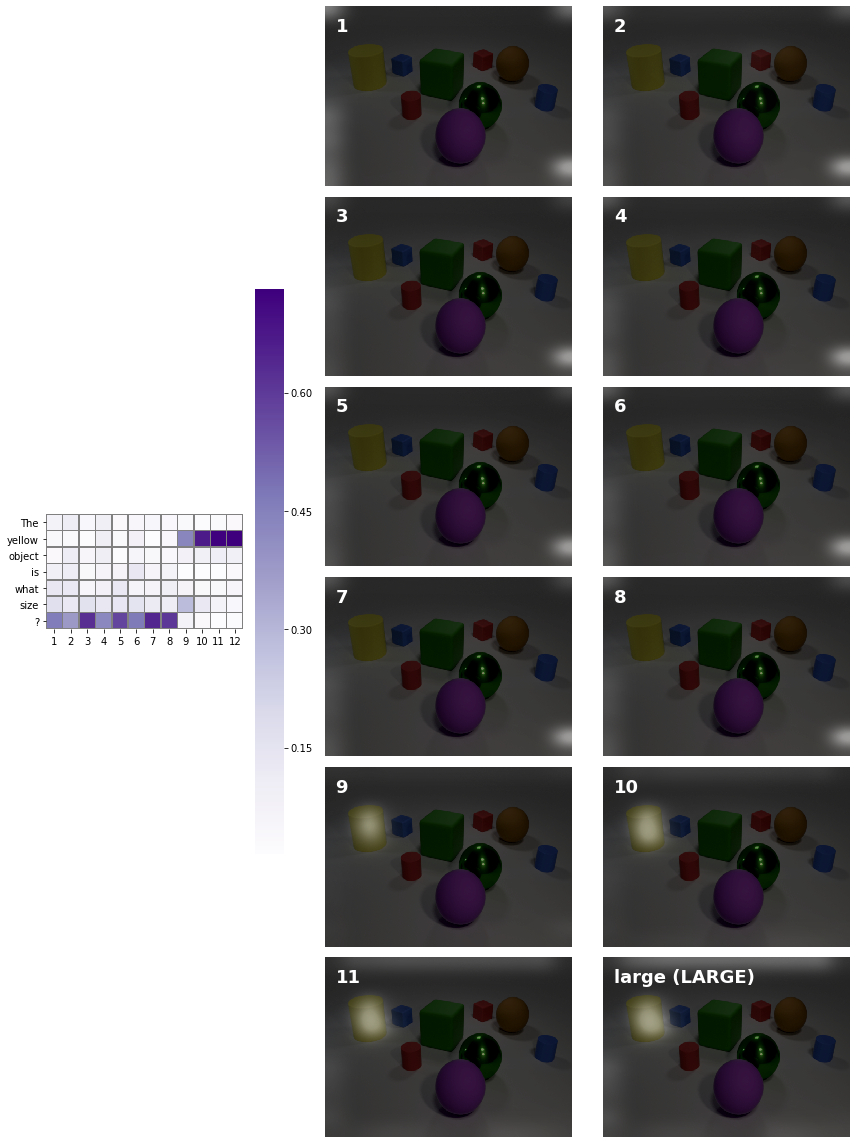

In [13]:
q_index = 15000
b = collate_fn([ds[q_index]])
with torch.no_grad():
    mid_outputs, output = mid_getter(b['image'], b['question'], b['question_length'])

pred = a_idx_to_tok[output[0].argmax().item()]
gt = a_idx_to_tok[b['answer'][0].item()]
    
plot_word_img_attn(
    mid_outputs,
    q_index,
    split,
    ds,
    num_steps=cfg.model.max_step,
    ds_root=ds_root,
    pred=pred,
    gt=gt,
)